<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Vinod_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 2.1 MB/s 


In [3]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [6]:
genes.head()
genes_Y_crom = genes[genes.chrom == "Y"].index

A.C. cortex
41158_at      0.950039
37743_at      0.631292
41123_s_at    0.608219
347_s_at      0.599001
40567_at      0.594510
33117_r_at    0.590882
33676_at      0.572482
32538_at      0.564630
37449_i_at    0.556419
38499_s_at    0.542464
dtype: float64
['PLP1', 'FEZ1', 'ENPP2', 'RPS23', NaN, 'RPS12', 'RPL31', 'TF', 'GNAS', 'MOBP']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
40326_at      0.428490
39864_at      0.427431
34526_s_at    0.413371
38285_at      0.371332
35098_at      0.366048
40847_at      0.360177
40435_at      0.340796
36308_at      0.331721
34277_at      0.316517
40887_g_at    0.300265
dtype: float64
['CBLN1', 'CIRBP', 'LOC157627', 'CRYM', 'GABRD', 'MICAL2', 'SLC25A6', 'ZIC1', 'CA11', 'EEF1A1']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

D.L.P.F. cortex
AFFX-HUMGAPDH/M33197_5_at    0.466037
34272_at                     0.438816
1161_at  

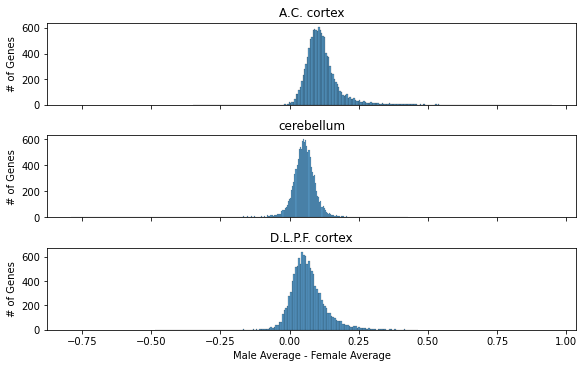

In [9]:
express_samp = pd.concat([expression, samples], axis=1)

express_samp.head()
fig, axs = plt.subplots(3, 1, figsize=(8, 5), constrained_layout=True, sharex='all')
express_samp_UM = express_samp[express_samp.lab == "Michigan"]
# print(express_samp_UM.head())
c = 0
for tissue in express_samp_UM["region"].unique():
  print(tissue)
  df_male = express_samp_UM[(express_samp_UM.region == tissue) & (express_samp_UM.sex == "male")]
  df_female = express_samp_UM[(express_samp_UM.region == tissue) & (express_samp_UM.sex == "female")]

  male_mean = expression.loc[df_male.index].mean().drop(genes_Y_crom)
  female_mean = expression.loc[df_female.index].mean().drop(genes_Y_crom)

  diff = male_mean - female_mean
  sns.histplot(diff, ax = axs[c])
  axs[c].set_title(tissue)
  axs[c].set_xlabel("Male Average - Female Average")
  axs[c].set_ylabel("# of Genes")
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  print(top_10)
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values
  print(op_genes)
  print("")
  c += 1





A.C. cortex
37259_at      0.842716
38957_at      0.668097
37183_at      0.570563
34393_r_at    0.568387
38484_at      0.563024
34677_f_at    0.554261
38462_at      0.549610
38839_at      0.536305
31526_f_at    0.532844
38708_at      0.526598
dtype: float64
['SERPINI1', 'DCLK1', 'GAD1', 'RAB1A', 'SNAP25', NaN, 'NDUFA5', 'PFN2', 'USP6', 'RAN']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'psiTPTE22']

cerebellum
37714_at                   1.117817
471_f_at                   1.077318
32744_at                   1.048820
33678_i_at                 1.033258
36567_at                   1.029537
AFFX-HSAC07/X00351_M_at    1.016441
40193_at                   1.012676
37450_r_at                 1.004883
38957_at                   0.997769
37669_s_at                 0.981077
dtype: float64
['GAP43', 'TUBB3', 'RPS21', 'TUBB2C', 'SLC17A7', 'ACTB', 'ENO2', 'GNAS', 'DCLK1', 'ATP1B1']
Categories (8783, object): ['AADAC', 'AAK1', 'AAMP', 'AANAT', ..., 'ZYX',

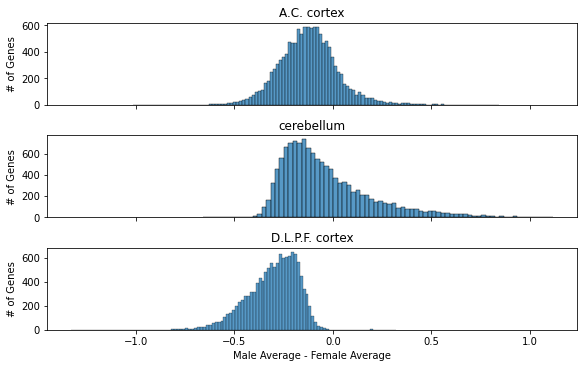

In [11]:
express_samp = pd.concat([expression, samples], axis=1)

express_samp.head()
fig, axs = plt.subplots(3, 1, figsize=(8, 5), constrained_layout=True, sharex='all')
express_samp_UM = express_samp[express_samp.lab == "Davis"]
# print(express_samp_UM.head())
c = 0
for tissue in express_samp_UM["region"].unique():
  print(tissue)
  df_male = express_samp_UM[(express_samp_UM.region == tissue) & (express_samp_UM.sex == "male")]
  df_female = express_samp_UM[(express_samp_UM.region == tissue) & (express_samp_UM.sex == "female")]

  male_mean = expression.loc[df_male.index].mean().drop(genes_Y_crom)
  female_mean = expression.loc[df_female.index].mean().drop(genes_Y_crom)

  diff = male_mean - female_mean
  sns.histplot(diff, ax = axs[c])
  axs[c].set_title(tissue)
  axs[c].set_xlabel("Male Average - Female Average")
  axs[c].set_ylabel("# of Genes")
  diff = diff.sort_values(ascending=False)
  top_10 = diff.iloc[:10]
  print(top_10)
  op_genes = genes.loc[top_10.keys()].loc[:, 'sym'].values
  print(op_genes)
  print("")
  c += 1
